In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import joblib
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

from audio import Audio

original_metadata_path = os.path.join(".", "data", "original_data_labeled.tsv")
filtered_metadata_path = os.path.join(".", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join(".", "data", "filtered_clips")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Clean and Load Dataset

Remove records of erroneous data (e.g. missing or corrupted audio files) from the dataset.

In [22]:
if not os.path.exists(filtered_metadata_path):
  df = pd.read_csv(original_metadata_path, sep='\t')

  # Remove unnecessary columns
  df.drop(columns=['client_id', 'sentence', 'age', 'gender', 'accent'], inplace=True, errors='ignore')

  # Filter out rows with missing labels
  df = df[df['label'].notna()]

  with open('error_file_paths.txt', 'r') as f:
      error_file_paths = f.read().splitlines()

  # Convert file paths to just the filename portion
  error_file_paths = [os.path.basename(path) for path in error_file_paths]

  # Remove rows with file paths in the error_file_paths list
  df.drop(df[df['path'].isin(error_file_paths)].index, inplace=True)

  valid_indices = []
  for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking files"):
    file_path = os.path.join(audio_dir, row['path'])
    if os.path.exists(file_path):
      valid_indices.append(idx)

  # Use only records with existing files
  df = df.loc[valid_indices]

  # Save the filtered DataFrame to a new TSV file
  df.to_csv(filtered_metadata_path, sep='\t', index=False)
else:
  df = pd.read_csv(filtered_metadata_path, sep='\t')

### Visualizations

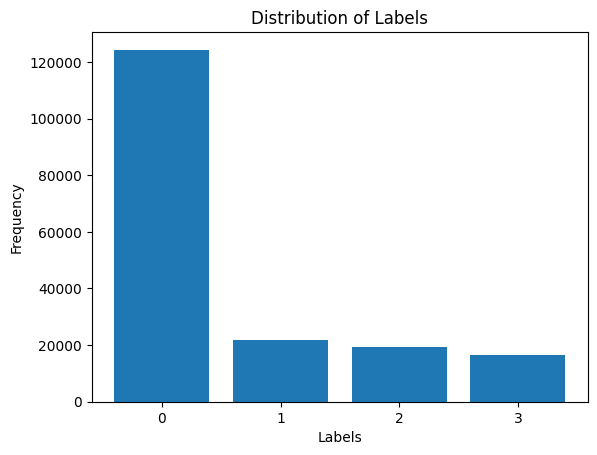

In [3]:
# Get sorted unique labels
labels = sorted(df['label'].unique())

# Define bin edges so bars are centered on labels
bin_edges = np.arange(min(labels) - 0.5, max(labels) + 1.5, 1)

plt.hist(df['label'], bins=bin_edges, rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(labels)  # Set ticks to the actual labels
plt.show()

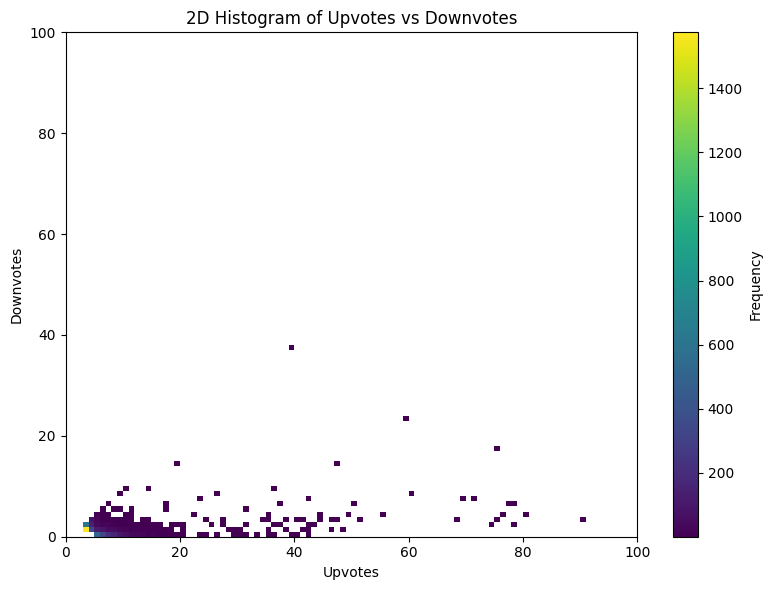

In [4]:
import matplotlib.pyplot as plt

# Create a 2D histogram (heatmap) of upvotes vs downvotes
plt.figure(figsize=(8, 6))
plt.hist2d(df['up_votes'], df['down_votes'], bins=(100, 100), range=[(0, 100), (0, 100)], cmap='viridis', cmin=1, cmax=2000)
plt.colorbar(label='Frequency')

plt.title("2D Histogram of Upvotes vs Downvotes")
plt.xlabel("Upvotes")
plt.ylabel("Downvotes")
plt.tight_layout()

plt.show()

Loading Training data

In [23]:
samples = 2000 #df['label'].value_counts().min()
balanced_samples = pd.DataFrame()
for cls in range(4): #df['label'].unique():
    cls_df = df[df['label'] == cls]
    sampled = cls_df.sample(n=samples, random_state=42)  # Random sampling
    balanced_samples = pd.concat([balanced_samples, sampled])

### Pipeline

In [24]:
from preprocessing.noise_reduction import NoiseReducer
from preprocessing.silence_removal import SilenceRemover
from preprocessing.dc_removal import DCRemover
from preprocessing.hpf import HPF
from preprocessing.quality_enhancer import QualityEnhancer
from preprocessing.light_loudness_normalization import LightLoudnessNormalizer
from preprocessing.speech_filter import SpeechFilter
from preprocessing.identity import Identity

from feature_extraction.mfcc import MFCC
from feature_extraction.fundamental_frequency import FundamentalFrequency
from feature_extraction.jitter import Jitter
from feature_extraction.hfcc import HFCC
from feature_extraction.cpps import CPPS
from feature_extraction.alpha_ratio import AlphaRatio
from feature_extraction.delta_mfcc import DeltaMFCC
from feature_extraction.pitch_range import PitchRange
from feature_extraction.pitch_range_paper import PitchRange2
from feature_extraction.spectral import SpectralFeatures
from feature_extraction.mean_min_max_frequeny import MeanMinMaxFrequency


In [33]:
noise_reducer = NoiseReducer()
silence_remover = SilenceRemover()
speech_filter = SpeechFilter()
identity = Identity()
dc_remover = DCRemover()
hpf = HPF()
lln = LightLoudnessNormalizer()
silence_remover = SilenceRemover(amplitude_threshold = 0.0005)
quality_enhancer = QualityEnhancer() 

fundamental_freq = FundamentalFrequency()
jitter = Jitter()
alpha_ratio = AlphaRatio()
cpps = CPPS()
hfcc = HFCC()
config = {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 48000}
mfcc = MFCC(config)
delta_mfcc = DeltaMFCC()
pitch_range = PitchRange()
pitch_range2 = PitchRange2()
spectral = SpectralFeatures()
mean_min_max_freq = MeanMinMaxFrequency()

feature_union = FeatureUnion([
    ('mfcc', mfcc),
    # ('fundamental_freq', fundamental_freq),
    # ('jitter', jitter),
    # ('spectral', spectral),
    # ('alpha_ratio', alpha_ratio),
    # ('cpps', cpps),
    # ('pitch_range', pitch_range),
    # ('pitch_range2', pitch_range2),
    # ('delta_mfcc', delta_mfcc),
    #('mean_min_max_freq', mean_min_max_freq),
    # ('hfcc', hfcc)
])

In [19]:
import random
import soundfile as sf

def augment_audio(audio, sr):
    """
    Augments an audio signal by applying random transformations.

    Args:
        audio (numpy.ndarray): The audio signal.
        sr (int): The sample rate of the audio.

    Returns:
        numpy.ndarray: The augmented audio signal.
    """
    # Randomly apply pitch shift
    if random.random() < 0.5:
        steps = random.uniform(-0.1, 0.1)  # Shift pitch by ±10%
        audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=steps * 12)

    # Randomly apply time stretch
    if random.random() < 0.5:
        rate = random.uniform(0.95, 1.05)  # Stretch by ±5%
        audio = librosa.effects.time_stretch(y=audio, rate=rate)

    # Randomly add noise
    if random.random() < 0.5:
        noise = np.random.normal(0, 0.005, audio.shape)
        audio = audio + noise

    # Randomly add mild background noise
    if random.random() < 0.5:
        background_noise = np.random.normal(0, 0.002, audio.shape)
        audio = audio + background_noise
    


    # Clip audio to ensure values are within valid range
    audio = np.clip(audio, -1.0, 1.0)

    return audio


def augment_and_add_data(df, target_class, augment_count):
    """
    Augments audio data for a specific class and adds it to the dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing audio data.
        target_class (int): The class for which data augmentation is performed.
        augment_count (int): The number of augmented samples to generate.

    Returns:
        pd.DataFrame: The updated dataframe with augmented data.
    """
    os.makedirs('./data/augmented_clips', exist_ok=True)
    
    class_df = df[df['label'] == target_class]
    augmented_data = []
    augmented_data_dir = "./data/augmented_clips"
    for _ in tqdm(range(augment_count), desc="Augmenting audio data"):
        sample = class_df.sample(n=1, random_state=random.randint(0, 1000)).iloc[0]
        file_path = os.path.join(audio_dir, sample['path'])
        audio, sr = librosa.load(file_path, sr=None)
        augmented_audio = augment_audio(audio, sr)
        augmented_file_path = f"{augmented_data_dir}/{sample['path'].split('.')[0]}_augmented.mp3"
        sf.write(augmented_file_path, augmented_audio, sr)

        augmented_data.append({
            'path': augmented_file_path,
            'up_votes': sample['up_votes'],
            'down_votes': sample['down_votes'],
            'label': sample['label']
        })

    augmented_df = pd.DataFrame(augmented_data)
    return pd.concat([df, augmented_df], ignore_index=True)



In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_pipe = make_pipeline(dc_remover, quality_enhancer, lln, silence_remover, feature_union, verbose=True)
feature_pipe

def process_in_chunks(df, pipeline, chunk_size=100):
    all_features = []
    all_labels = []

    for i in tqdm(range(0, len(df), chunk_size), desc="Processing chunks"):
        chunk = df.iloc[i:i+chunk_size]
        filenames = chunk['path'].tolist()
        audios = []
        for filename in filenames:
            if "augmented" in filename:
                audio, sr = librosa.load(os.path.join(filename), sr=None)
            else:
                audio, sr = librosa.load(os.path.join(audio_dir, filename), sr=None)
            audios.append(Audio(audio, sr))
        labels = chunk['label'].values

        features = pipeline.transform(audios)

        all_features.append(np.array(features))
        all_labels.append(labels)

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

df_train, df_test = train_test_split(balanced_samples, test_size=0.2, random_state=42, stratify=balanced_samples['label'])

X_train, y_train = process_in_chunks(df_train, feature_pipe)
X_train_scaled = scaler.fit_transform(X_train)

X_test, y_test = process_in_chunks(df_test, feature_pipe)
X_test_scaled = scaler.transform(X_test)

Processing chunks:   0%|          | 0/64 [00:00<?, ?it/s]e:\CCE\Senior-2\Spring\Pattern Recognition\Project\Speaker-Gender-And-Age-Recognition\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Processing chunks:   0%|          | 0/16 [00:00<?, ?it/s]e:\CCE\Senior-2\Spring\Pattern Recognition\Project\Speaker-Gender-And-Age-Recognition\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Processing chunks: 100%|██████████| 16/16 [01:39<00:00,  6.24s/it]


In [14]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)  # X is your dataset
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

[0.46146904 0.65538048 0.72954973 ... 1.         1.         1.        ]


In [24]:
print(cumulative_variance[150:151])


[0.99979256]


In [29]:
pca = PCA(n_components=150, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original number of features:", X_train.shape[1])
print("Reduced number of features:", X_train_pca.shape[1])

Original number of features: 3150
Reduced number of features: 150


In [30]:
from models.svm import SVM
from models.extra_tree import ExtraTree
from models.knn import KNN
from models.gradient_boost import GradientBoost
from models.logistic_regression import LogisticRegression
from models.qda import QDA
from xgboost import XGBClassifier

svm = SVM()
extra_tree = ExtraTree()
knn = KNN()
gradient_boost = GradientBoost()
logistic_regression = LogisticRegression()
qda = QDA()


In [31]:
svm = SVM()
model_pipe = make_pipeline(svm, verbose=True)
model_pipe = model_pipe.fit(X_train_pca, y_train)

[Pipeline] ............... (step 1 of 1) Processing svm, total=   5.5s


In [16]:
etc = ExtraTree()
model_pipe = make_pipeline(etc, verbose=True)
model_pipe = model_pipe.fit(X_train_pca, y_train)

[Pipeline] ......... (step 1 of 1) Processing extratree, total= 1.6min


check underfitting

In [7]:
y_pred = model_pipe.predict(X_train_pca)
print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred))

KeyboardInterrupt: 

check overfitting

In [32]:
y_pred = model_pipe.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       400
           1       0.85      0.90      0.87       400
           2       0.85      0.83      0.84       400
           3       0.93      0.85      0.89       400

    accuracy                           0.85      1600
   macro avg       0.85      0.85      0.85      1600
weighted avg       0.85      0.85      0.85      1600


Confusion Matrix:
[[325  15  50  10]
 [ 19 360   5  16]
 [ 56  10 334   0]
 [ 17  38   4 341]]


In [14]:
pipe = make_pipeline(
    feature_pipe,
    model_pipe
)

In [15]:
from joblib import dump
import time
import os
import json

# Create a folder for the model
timestamp = time.strftime("%d_%m_%Y_T%H_%M_%S")
model_folder = f'trials/model_{timestamp}'
os.makedirs(model_folder, exist_ok=True)

# Save the model
model_path = os.path.join(model_folder, 'model.joblib')
dump(pipe, model_path)

# Save evaluation metrics
evaluation = {
  "architecture": str([step[0] for step in pipe.steps]),
  "accuracy": float(accuracy_score(y_test, y_pred)),
  "classification_report": classification_report(y_test, y_pred, output_dict=True),
  "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}

# Save evaluation as JSON
eval_path = os.path.join(model_folder, 'evaluation.json')
with open(eval_path, 'w') as f:
  json.dump(evaluation, f, indent=4)

print(f"Model and evaluation saved in folder: {model_folder}")

Model and evaluation saved in folder: trials/model_21_04_2025_T15_05_46


In [ ]:
from joblib import dump
import os

# Define paths to save the feature vectors
feature_folder = "trials/features/mfcc3350"
os.makedirs(feature_folder, exist_ok=True)

X_train_path = os.path.join(feature_folder, "X_train.joblib")
y_train_path = os.path.join(feature_folder, "y_train.joblib")
X_test_path = os.path.join(feature_folder, "X_test.joblib")
y_test_path = os.path.join(feature_folder, "y_test.joblib")

# Save the feature vectors
dump(X_train, X_train_path)
dump(y_train, y_train_path)
dump(X_test, X_test_path)
dump(y_test, y_test_path)

print(f"Feature vectors saved in folder: {feature_folder}")

Feature vectors saved in folder: trials/features/mfcc3350


In [3]:
feature_folder = "trials/features/mfcc3150"

X_train_path = os.path.join(feature_folder, "X_train.joblib")
y_train_path = os.path.join(feature_folder, "y_train.joblib")
X_test_path = os.path.join(feature_folder, "X_test.joblib")
y_test_path = os.path.join(feature_folder, "y_test.joblib")


X_train = joblib.load(X_train_path)
y_train = joblib.load(y_train_path)
X_test = joblib.load(X_test_path)
y_test = joblib.load(y_test_path)

In [ ]:
from playsound import playsound

def play_sound(file_path):
    """
    Play a sound file.

    Args:
        file_path (str): Path to the sound file.
    """
    try:
        playsound(file_path)
        playsound(file_path)
    except Exception as e:
        print(f"Error playing sound: {e}")

play_sound("../sound/done.mp3")

Grid Searching 🔎

In [ ]:

param_grid = {
  'n_estimators': [100, 200],
  'max_depth': [3, 5, 7, 10],
  'learning_rate': [0.1, 0.01],
  'subsample': [0.8, 1],
  'colsample_bytree': [0.8, 1],
}

# Create XGBClassifier for gender model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Custom fit loop with tqdm progress bar for each fit
grid = RandomizedSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# Print the best score and parameters
print("Best Model Score:", grid.best_score_)
print("Best Model Params:", grid.best_params_)

# Make predictions
y_pred = grid.best_estimator_.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import itertools
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Define grid
n_mfcc_options = [75]           # Adding 40 as a middle ground for MFCCs
n_fft_options = [2048]                      # Keep n_fft at 512 and 1024
hop_length_options = [512]             # A wider range for hop_length
context_options = [3]                         # Keep context stacking for ±1
use_spectral_subtraction_options = [False]       # Keeping spectral subtraction off
use_smoothing_options = [True]                  # No smoothing
use_cmvn_options = [False]                        # Keep CMVN enabled
use_deltas_options = [True]               # Try both with and without deltas

# Build all combinations
param_grid = list(itertools.product(
    n_mfcc_options,
    n_fft_options,
    hop_length_options,
    context_options,
    use_spectral_subtraction_options,
    use_smoothing_options,
    use_cmvn_options,
    use_deltas_options
))

print(f"Total configs to try: {len(param_grid)}")

# 3. Setup for tracking best model
best_score = 0
best_params = None

# Instantiate scaler once
scaler = StandardScaler()

df_train, df_test = train_test_split(balanced_samples, test_size=0.2, random_state=42, stratify=balanced_samples['label'])

# Iterate through all parameter combinations
for params in tqdm(param_grid, desc="Grid Search"):

    (n_mfcc, n_fft, hop_length, context,
    use_spectral_subtraction, use_smoothing, use_cmvn, use_deltas) = params

    # 4. Build config dictionary
    config = {
        "n_mfcc": n_mfcc,
        "n_fft": n_fft,
        "hop_length": hop_length,
        "context": context,
        "use_spectral_subtraction": use_spectral_subtraction,
        "use_smoothing": use_smoothing,
        "use_cmvn": use_cmvn,
        "use_deltas": use_deltas,
        "sr": 40000
    }

    # 5. Create pipeline
    feature_union = FeatureUnion([
        ('mfcc', MFCC(config)),
    ])
    feature_pipe = make_pipeline(dc_remover, quality_enhancer, lln, silence_remover, feature_union, verbose=True)

    # 6. Process training set
    X_train, y_train = process_in_chunks(df_train, feature_pipe)
    X_train_scaled = scaler.fit_transform(X_train)

    # 7. Process test set
    X_test, y_test = process_in_chunks(df_test, feature_pipe)
    X_test_scaled = scaler.transform(X_test)

    # Fit PCA on training data to retain 99% variance
    pca = PCA(n_components=0.99, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("Original number of features:", X_train.shape[1])
    print("Reduced number of features:", X_train_pca.shape[1])

    # 8. Train an XGBoost model
    clf = XGBClassifier(
        max_depth=10,                # Common depth to avoid overfitting
        learning_rate=0.1,          # Standard learning rate
        n_estimators=200,           # Number of boosting rounds
        subsample=0.8,              # Subsample for each tree
        colsample_bytree=0.8,       # Feature subsample per tree
        objective='multiclass', # Assuming binary classification
        use_label_encoder=False,    # Avoid warning with label encoder
        eval_metric='logloss'       # Logloss is a common metric for classification
    )
    clf.fit(X_train, y_train)
    score0 = clf.score(X_test, y_test)
    print(f"XGBoost Params: {config} → Accuracy: {score0:.4f}")

    clf = SVM()
    clf.fit(X_train, y_train)
    score1 = clf.score(X_test, y_test)
    print(f"SVM Params: {config} → Accuracy: {score1:.4f}")

    clf = SVM()
    clf.fit(X_train_scaled, y_train)
    score2 = clf.score(X_test_scaled, y_test)
    print(f"SCALED Params: {config} → Accuracy: {score2:.4f}")

    clf = SVM()
    clf.fit(X_train_pca, y_train)
    score3 = clf.score(X_test_pca, y_test)
    print(f"PCA Params: {config} → Accuracy: {score3:.4f}")

    # 10. Track best
    max_score = max(score0, score1, score2, score3)
    if max_score > best_score:
        best_score = max_score
        best_params = config

print(f"\n🏆 Best score {best_score:.4f} with params:\n{best_params}")

Total configs to try: 1


Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]e:\CCE\Senior-2\Spring\Pattern Recognition\Project\Speaker-Gender-And-Age-Recognition\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Processing chunks: 100%|██████████| 64/64 [05:36<00:00,  5.26s/it]
e:\CCE\Senior-2\Spring\Pattern Recognition\Project\Speaker-Gender-And-Age-Recognition\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Processing chunks: 100%|██████████| 16/16 [01:20<00:00,  5.05s/it]


Original number of features: 3150
Reduced number of features: 53


e:\CCE\Senior-2\Spring\Pattern Recognition\Project\Speaker-Gender-And-Age-Recognition\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:15:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Params: {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 40000} → Accuracy: 0.7819
SVM Params: {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 40000} → Accuracy: 0.8475
SCALED Params: {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 40000} → Accuracy: 0.7669


Grid Search: 100%|██████████| 1/1 [17:46<00:00, 1066.64s/it]

PCA Params: {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 40000} → Accuracy: 0.8456

🏆 Best score 0.8475 with params:
{'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 'use_spectral_subtraction': False, 'use_smoothing': True, 'use_cmvn': False, 'use_deltas': True, 'sr': 40000}
